# Surprise Housing - Advanced Regression
### Description
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price.
The company is looking at prospective properties to buy to enter the market. We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

### Business Goal
The objective is to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

### Technical Goal
To use Multiple Linear Regression to build a model to predict the key factors that affect the price of rentals from the given dataset. 
The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

### Steps Followed in Model Building
1. Data Sourcing
2. Data Cleaning and Feature Engineering
3. Data Understanding
4. Data Visualization
5. Data Preparation
6. Model Building and Evaluation
7. Model Interpretation
8. Addressing the Business Problem

### Subjective Questions
The code relevant for the subjective questions are written in the end.

# Step 1. Data Sourcing

In [1]:
# Import necessary header files

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import pandas as pd
import numpy as np
import missingno as msno

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis and modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
# Load the dataset
housing = pd.read_csv('train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Overview

In [4]:
# Structure of the dataset
housing.shape

(1460, 81)

The dataset has `81 columns` and `1460 rows` of data. Since we have 81 columns, let's remove columns that we do not need and then go ahead and further understand the data.

# Step 2. Data Cleaning and Feature Engineering

### Drop duplicate data

In [5]:
housing = housing.drop_duplicates()
housing.shape

(1460, 81)

### Drop columns with more than 80% missing values

<Axes: >

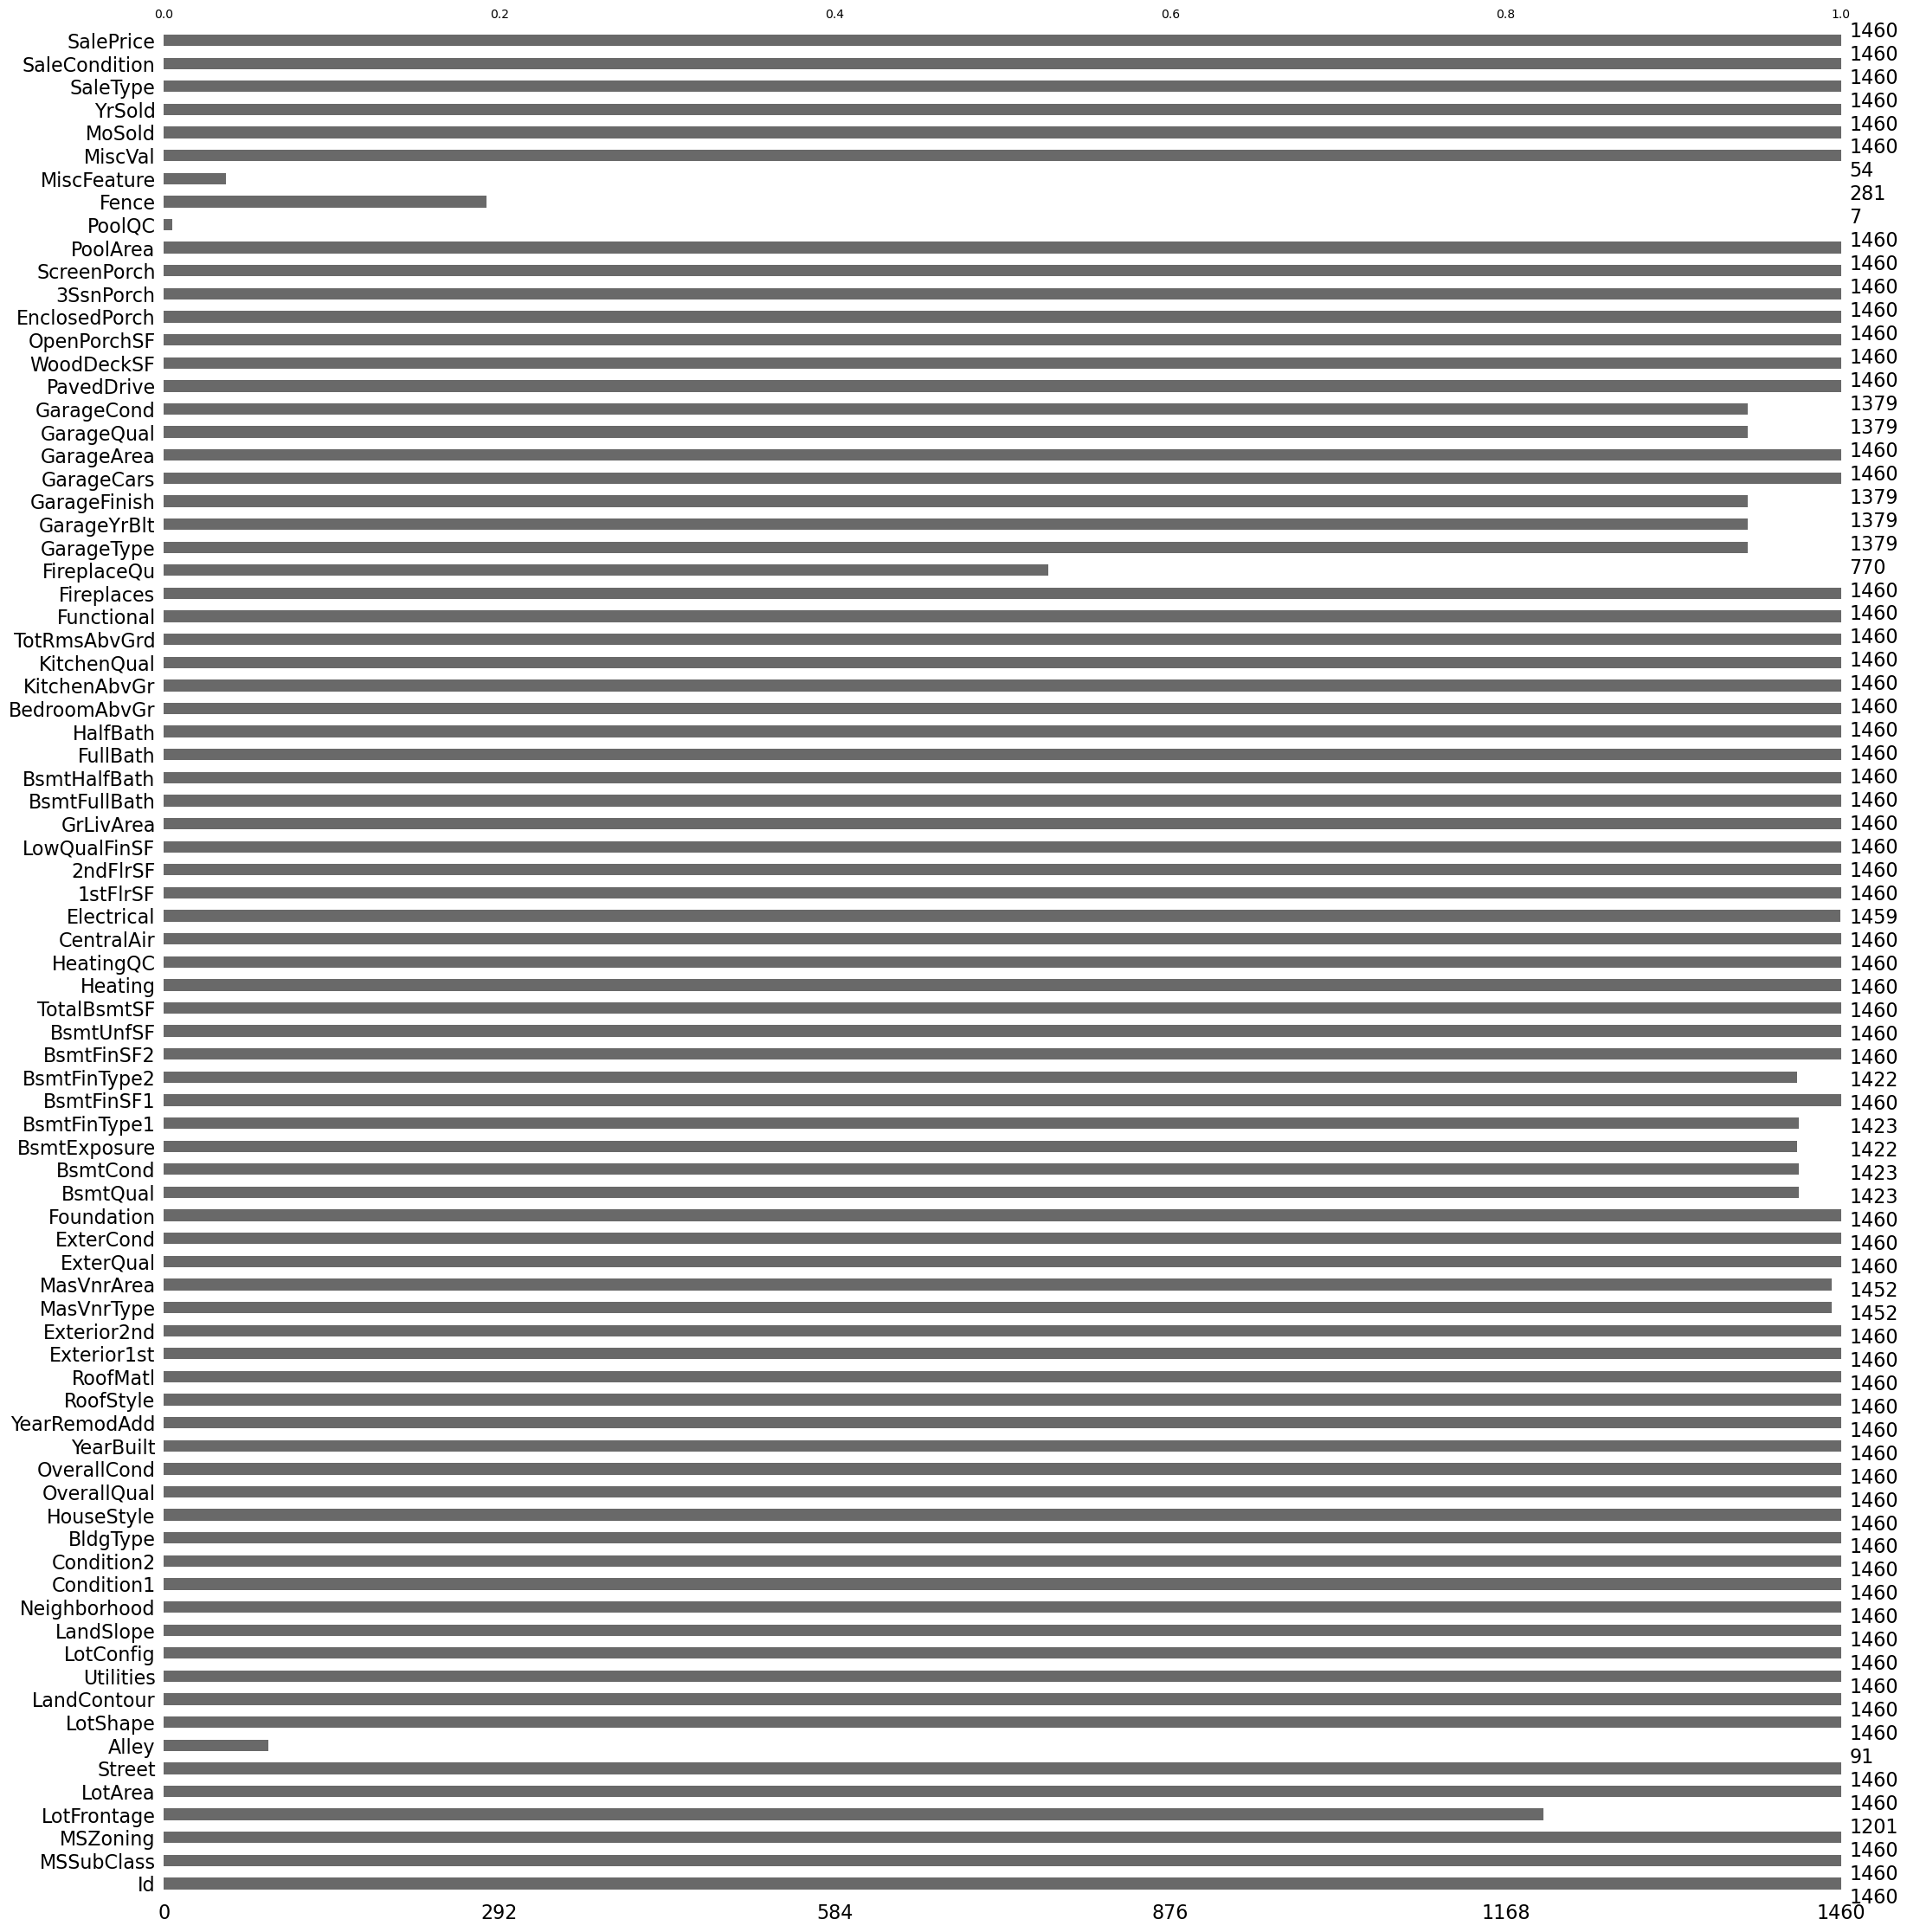

In [6]:
# Using missingno library, identify columns with more than 80% missing values
msno.bar(housing)

We see columns `MiscFeature`, `Fence`, `PoolQC`, `Alley` have more than 80% missing data. So, we will drop these columns.

In [7]:
# Columns drop
housing = housing.drop(['MiscFeature','Fence','PoolQC','Alley'], axis=1)
housing.shape

(1460, 77)

### Drop categorical columns with more than 80% values being just one value. 
These are columns with biased data

In [8]:
# Get value counts for all columns

biased_columns = []
for column in housing.columns:
    value_counts = housing[column].value_counts()
    total_count = len(housing[column])
    
    # Check if the most common value occurs more than 80% of the time
    most_common_value_count = value_counts.iloc[0]
    if most_common_value_count / total_count > 0.8:
        biased_columns.append(column)

print("Number of columns with biased data:",len(biased_columns))
print("We will drop them.")

Number of columns with biased data: 29
We will drop them.


In [9]:
# List of biased columns that will be dropped next
biased_columns

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SaleType',
 'SaleCondition']

In [10]:
# Columns drop
housing = housing.drop(columns=biased_columns)
housing.shape

(1460, 48)

### Impute columns with missing values

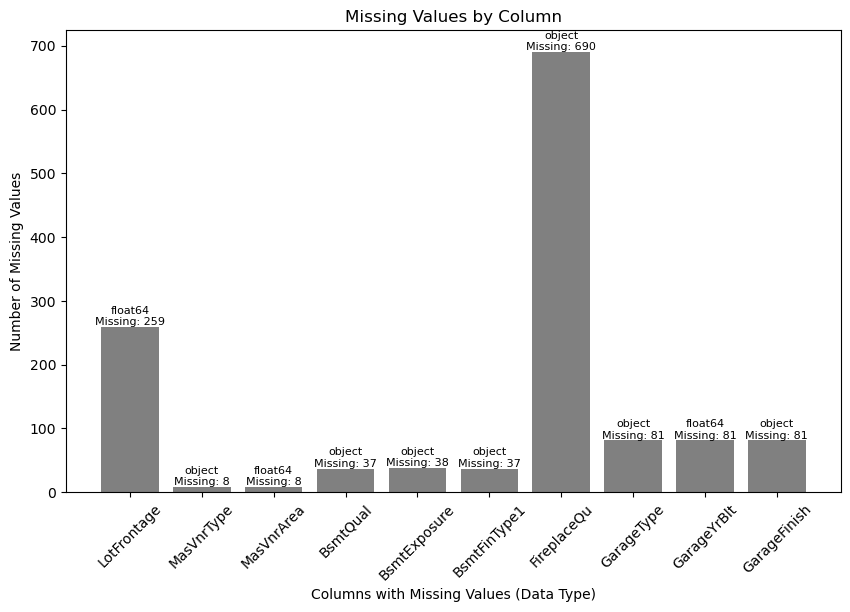

In [11]:
# Identify remaining columns with missing values

columns_with_missing_values = housing.columns[housing.isnull().any()].tolist()
column_data_types = housing[columns_with_missing_values].dtypes

# Create a custom bar chart for columns with missing values
plt.figure(figsize=(10, 6))
plt.bar(columns_with_missing_values, housing[columns_with_missing_values].isnull().sum(), color='grey')
plt.xlabel('Columns with Missing Values (Data Type)')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values by Column')
plt.xticks(rotation=45)

# Mark the column bars with their corresponding data types
for i, (dtype, missing_count) in enumerate(zip(column_data_types, housing[columns_with_missing_values].isnull().sum())):
    plt.annotate(f'{dtype}\nMissing: {missing_count}', (i, missing_count), ha='center', va='bottom', fontsize=8)
plt.show()

We will analyse every column from a business and logical perspective before deciding how the imputaion has to happen fot these columns

#### MasVnrType and MasVnrArea
- We see that the missing value count in both the columns is the same. 
- We can use this detail to impute both the columns.
- `MasVnrType`, being a categorical variable, let us determine what is the mode value for it.

In [12]:
mode_MasVnrType = housing['MasVnrType'].mode()[0]
print('Mode value for MasVnrType is:', mode_MasVnrType)

Mode value for MasVnrType is: None


In [13]:
# Checking corresponding `MasVnrArea` values to make sure mode can be used to impute `MasVnrType`
housing[housing['MasVnrType'].isnull()==True]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

- Practically, if there is no Masonary Veneer Area, there is no Masonary Veneer Type to determine. Using this logic, 
    - we will set the missing values of `MasVnrArea` to zero and
    - impute the missing values in `MasVnrType` with the mode value `None`.

In [14]:
housing['MasVnrType'].fillna(mode_MasVnrType, inplace=True)
housing['MasVnrArea'].fillna(0, inplace=True)

#### BsmtQual, BsmtExposure, BsmtFinType1
According to data dictionary, null values represent no availability of basement in the houses. Therefore, we will impute these values with `None`.

In [15]:
no_basement = 'None'
housing['BsmtQual'].fillna(no_basement, inplace=True)
housing['BsmtExposure'].fillna(no_basement, inplace=True)
housing['BsmtFinType1'].fillna(no_basement, inplace=True)

#### GarageType, GarageYrBlt, GarageFinish
- According to the data dictionary, null values in `GarageType` represent no garage available. 
- From the above graph it is clear that the count of missing values in the garage related three columns is teh same.

In [16]:
garage_condition = ((housing['GarageType'].isnull()) & (housing['GarageYrBlt'].isnull()) & (housing['GarageFinish'].isnull())).sum()
print('The number of rows with missing values in all three garage-based columns is',garage_condition)

The number of rows with missing values in all three garage-based columns is 81


This is the same number of missing value count in the graph. Therefore, we can safely impute all three columns to None/0 (object/float)

In [17]:
housing['GarageType'].fillna('None', inplace=True)
housing['GarageYrBlt'].fillna(0, inplace = True)
housing['GarageFinish'].fillna(0, inplace = True)

#### LotFrontage

Let's plot a boxplot to check for outliers.

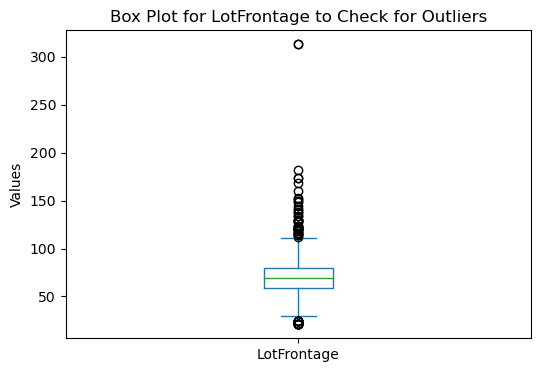

In [18]:
plt.figure(figsize=(6, 4))
housing['LotFrontage'].plot(kind='box')
plt.title('Box Plot for LotFrontage to Check for Outliers')
plt.ylabel('Values')
plt.show()

#### Analysis:
- From the graph, we can see that the `LotFrontage` column has a lot of outliers.
- Therefore, the missing values here will be imputed with the median value.

In [19]:
median_LotFrontage = housing['LotFrontage'].median()
housing['LotFrontage'].fillna(median_LotFrontage, inplace=True)

#### FireplaceQu
According to data dictionary, null values in `FireplaceQU` indicate no fireplace. Therefore, we will impute the missing values with `None`.

In [20]:
housing['FireplaceQu'].fillna('None', inplace=True)

### Drop id column

In [21]:
housing = housing.drop('Id', axis=1)

#### Column: TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtFinSF1
Therefore, we will drop BsmtFinSF1 and BsmtFinSF1. BsmtFinSF2 is already dropped above.

In [22]:
housing = housing.drop(columns = ['BsmtFinSF1','BsmtUnfSF'], axis = 1)
housing.shape

(1460, 45)

#### Columns: Exterior1st, Exterior2nd
Check what percentage of values in both the columns are different. If it is more than 20%, keep both columns. Else, drop one of the columsn for simplicity

In [23]:
ext = housing[['Exterior1st','Exterior2nd']]
ext = ext.apply(lambda x:x.nunique(), axis=1)
print('Percentage of rows with differing values in Exterioir related columns:', 
      round((len(ext[ext > 1])/housing.shape[0])*100,2))

Percentage of rows with differing values in Exterioir related columns: 14.73


Since only 14.73% of rows have unique values, we will drop Exterior2nd.

In [24]:
housing = housing.drop('Exterior2nd', axis=1)
housing.shape

(1460, 44)

### Feature Engineering/Derived Metrics
Derive meaningful columns from given columns

#### Total SquareFeet
Total square feet of the enclosed house = TotalBsmtSF + 1stFlrSF + 2ndFlrSF

In [25]:
housing['TotalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
housing = housing.drop(columns=['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1)
housing.shape

(1460, 42)

#### Convert all year columns to age - YearBuilt, YearRemodAdd, GarageYrBlt, YrSold

In [26]:
# Use col.max() to scale the values
housing['YearBuilt'] = housing['YearBuilt'].max() - housing['YearBuilt']
housing['YearRemodAdd'] = housing['YearRemodAdd'].max() - housing['YearRemodAdd']
housing['GarageYrBlt'] = housing['GarageYrBlt'].max() - housing['GarageYrBlt']
housing['YrSold'] = housing['YrSold'].max() - housing['YrSold']

# Step 3. Data Understanding

In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 42 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   int64  
 1   MSZoning      1460 non-null   object 
 2   LotFrontage   1460 non-null   float64
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   int64  
 9   OverallCond   1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  RoofStyle     1460 non-null   object 
 13  Exterior1st   1460 non-null   object 
 14  MasVnrType    1460 non-null   object 
 15  MasVnrArea    1460 non-null   float64
 16  ExterQual     1460 non-null   object 
 17  Foundation    1460 non-null   object 
 18  BsmtQual      1460 non-null 

### Data Categorization
Categorize the given columns into numeric and categorical by understanding every column. This will help us in outlier treatment, dummy variable creation, ordinal encording.

#### Numeric
SalePrice - Dependent variable
LotFrontage
LotArea
YearBuilt
YearRemodAdd
MasVnrArea
GrLivArea
BsmtFullBath
FullBath
HalfBath
BedroomAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
YrSold
TotalSF

#### Categorical: Nominal
MSSubClass
MSZoning
LotConfig
Neighborhood
HouseStyle
RoofStyle
Exterior1st
MasVnrType
Foundation
GarageType
MoSold

#### Categorical: Ordinal
LotShape
OverallQual
OverallCond
ExterQual
BsmtQual
BsmtExposure
BsmtFinType1
HeatingQC
KitchenQual
FireplaceQu
GarageFinish

# Step 4. Data Visualization: EDA
Visualizing data helps us

- Identify if some predictors directly have a strong association with the outcome variable `SalePrice`.
- Verify if there is some obvious multicollinearity going on between pairs of variables.

### Numeric Variables

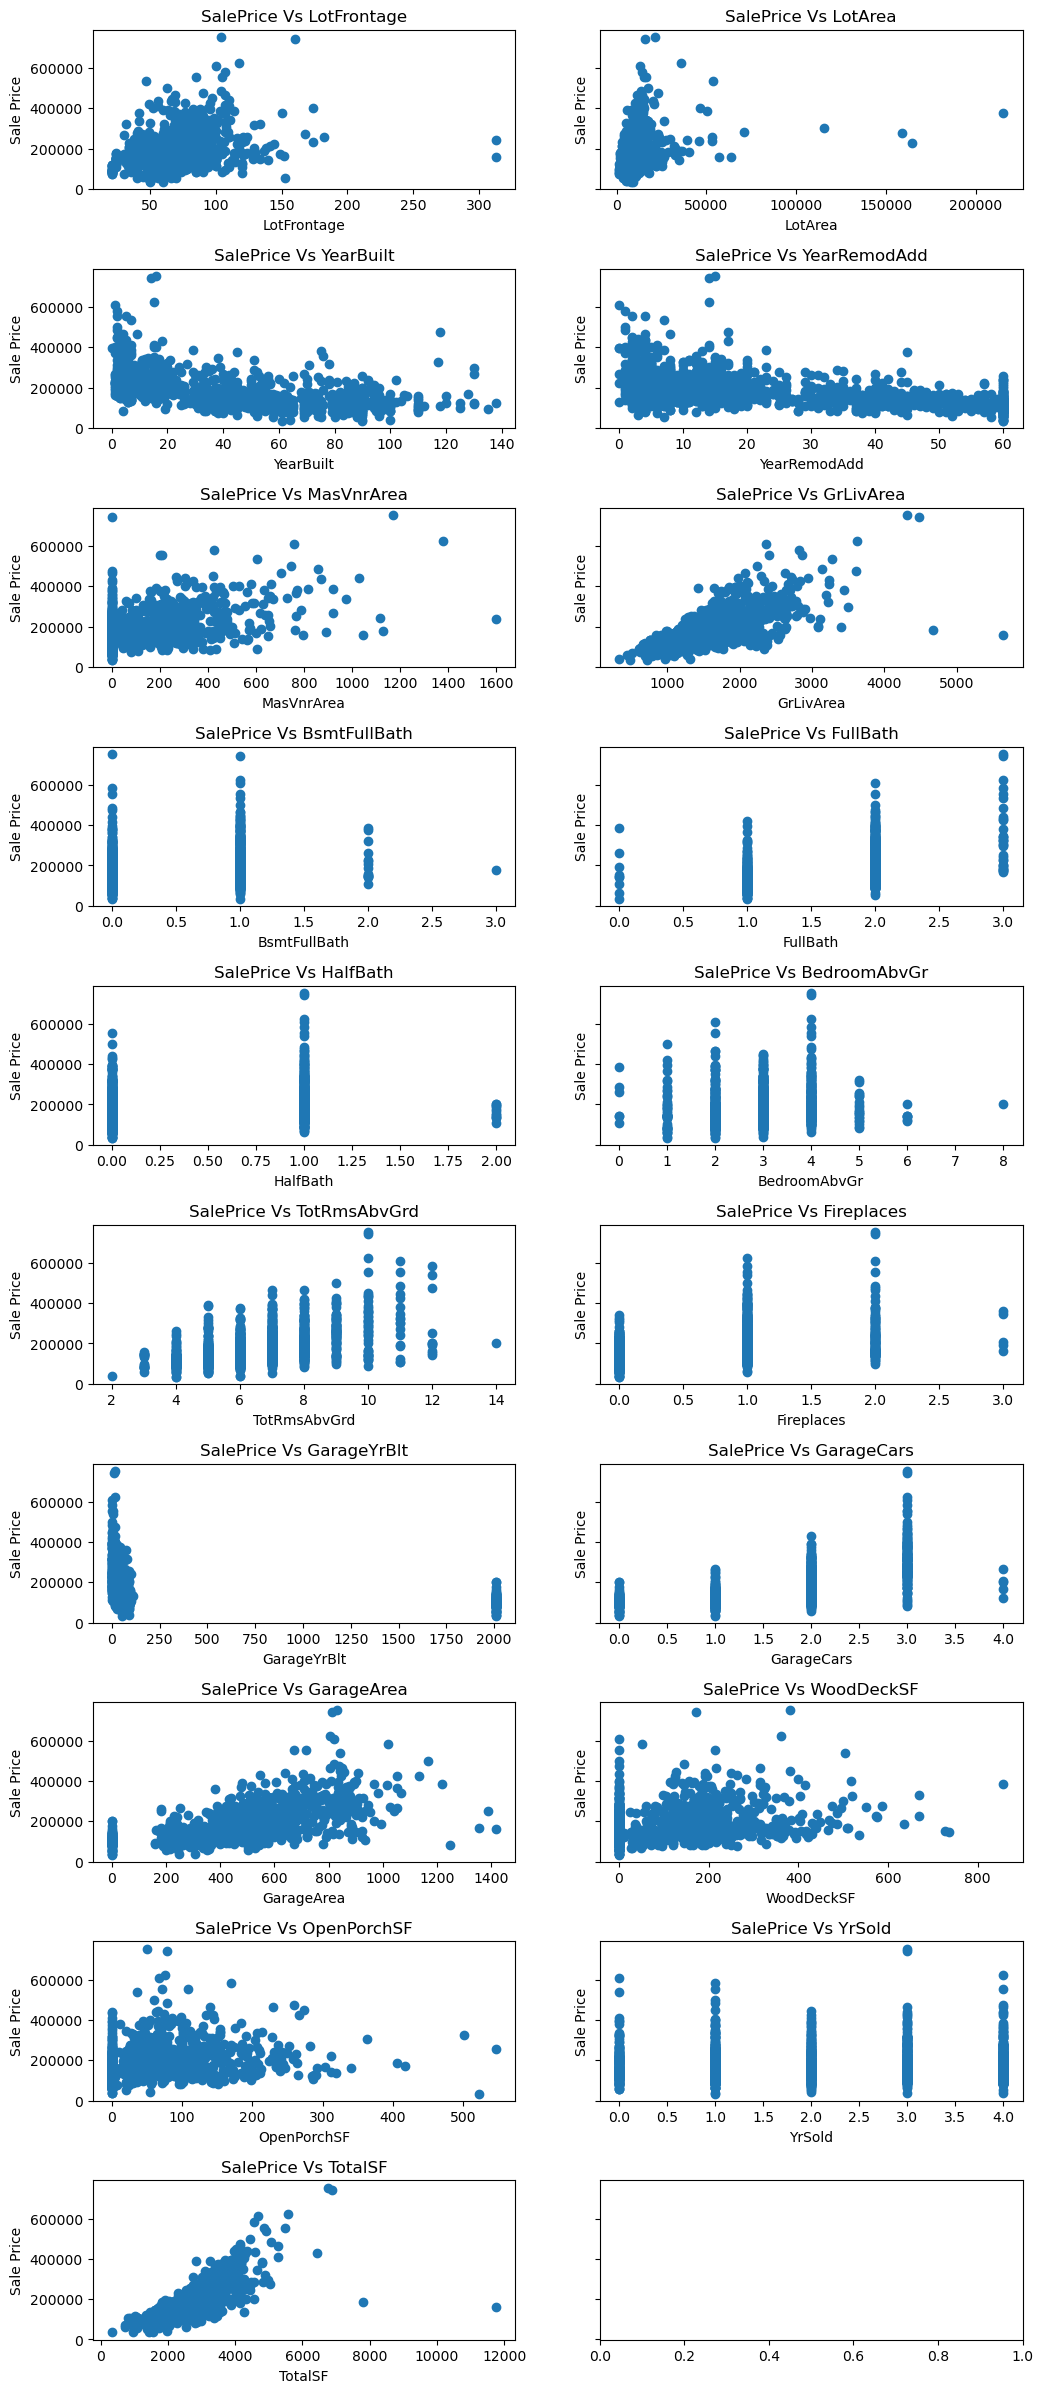

In [28]:
# Group numeric columns
numeric_col = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 
               'MasVnrArea', 'GrLivArea', 'BsmtFullBath', 'FullBath', 
               'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
               'OpenPorchSF', 'YrSold', 'TotalSF']

# Create sublists to ease plot creation
sublist_size = 2
numeric_sublist = [numeric_col[i:i + sublist_size] for i in range(0, len(numeric_col), sublist_size)]

# Scatter plot for all numeric variables
fig, axes = plt.subplots(10, 2, figsize=(12, 30), sharey=True)
fig.subplots_adjust(hspace=0.5)
for i in range(10):
    for j in range(2):
        if j < len(numeric_sublist[i]):
            col = numeric_sublist[i][j]
            axes[i, j].scatter(housing[col], housing['SalePrice'])
            title = 'SalePrice Vs '+ col
            axes[i, j].set_title(title)
            axes[i, j].set_xlabel(col)
            axes[i, j].set_ylabel('Sale Price')

plt.show()

To perform linear regression, the (numeric) target variable should be linearly related to at least one another numeric variable. From the above graphs, it is clear that variables related to area in particular are linearly related with `Sale Price`. Therefore, we can go ahead with Multiple Linear Regression.

#### Outlier Treatment
We also see some outliers from the above graphs. Let us analyze the data further and perform outlier treatment using `interquartile ranges`.

In [29]:
# Analyse arithmetic parameters of numeric variables
housing.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,BsmtFullBath,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,TotalSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,38.732192,25.134247,103.117123,1515.463699,0.425342,...,0.613014,141.260274,1.767123,472.980137,94.244521,46.660274,6.321918,2.184247,180921.195890,2567.048630
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,525.480383,0.518911,...,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,2.703626,1.328095,79442.502883,821.714421
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,34900.000000,334.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,10.000000,6.000000,0.000000,1129.500000,0.000000,...,0.000000,9.000000,1.000000,334.500000,0.000000,0.000000,5.000000,1.000000,129975.000000,2009.500000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,37.000000,16.000000,0.000000,1464.000000,0.000000,...,1.000000,33.000000,2.000000,480.000000,0.000000,25.000000,6.000000,2.000000,163000.000000,2474.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,56.000000,43.000000,164.250000,1776.750000,1.000000,...,1.000000,52.000000,2.000000,576.000000,168.000000,68.000000,8.000000,3.000000,214000.000000,3004.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,138.000000,60.000000,1600.000000,5642.000000,3.000000,...,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,12.000000,4.000000,755000.000000,11752.000000


In [30]:
# Determine skewness for all numeric variables
housing.skew()

MSSubClass       1.407657
LotFrontage      2.409147
LotArea         12.207688
OverallQual      0.216944
OverallCond      0.693067
YearBuilt        0.613461
YearRemodAdd     0.503562
MasVnrArea       2.677616
GrLivArea        1.366560
BsmtFullBath     0.596067
FullBath         0.036562
HalfBath         0.675897
BedroomAbvGr     0.211790
TotRmsAbvGrd     0.676341
Fireplaces       0.649565
GarageYrBlt      3.869501
GarageCars      -0.342549
GarageArea       0.179981
WoodDeckSF       1.541376
OpenPorchSF      2.364342
MoSold           0.212053
YrSold          -0.096269
SalePrice        1.882876
TotalSF          1.776700
dtype: float64

The recommended skewness value range is around `-1 to 1` but we see 10 columns that exceed this range and therefore, let's perform outlier treatment.

In [31]:
# Outlier treatment using IQR - to remove outliers from dataset
def outlier_treatment(df, column_name):
    Q1 = df[column_name].quantile(0.10)
    Q3 = df[column_name].quantile(0.80)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

# Apply the outlier treatment to each column in the list
for column in numeric_col:
    housing = outlier_treatment(housing, column)
housing.shape

(1175, 42)

In [32]:
# Checking skewness after outlier treatment
housing.skew()

MSSubClass      1.380738
LotFrontage    -0.028859
LotArea         0.381944
OverallQual     0.146427
OverallCond     0.795606
YearBuilt       0.559578
YearRemodAdd    0.508277
MasVnrArea      1.473111
GrLivArea       0.502984
BsmtFullBath    0.446190
FullBath       -0.028275
HalfBath        0.645603
BedroomAbvGr   -0.342914
TotRmsAbvGrd    0.276142
Fireplaces      0.528955
GarageYrBlt     0.603965
GarageCars      0.107216
GarageArea      0.552700
WoodDeckSF      1.050275
OpenPorchSF     1.269195
MoSold          0.241385
YrSold         -0.092465
SalePrice       1.115910
TotalSF         0.330874
dtype: float64

We see a tremendous imporvement in the skewness values and therefore, we will use this dataset now.
Let's look at the correlation matrix to look for patterns of multicollinearity amongst numeric variables.

#### Correlation check

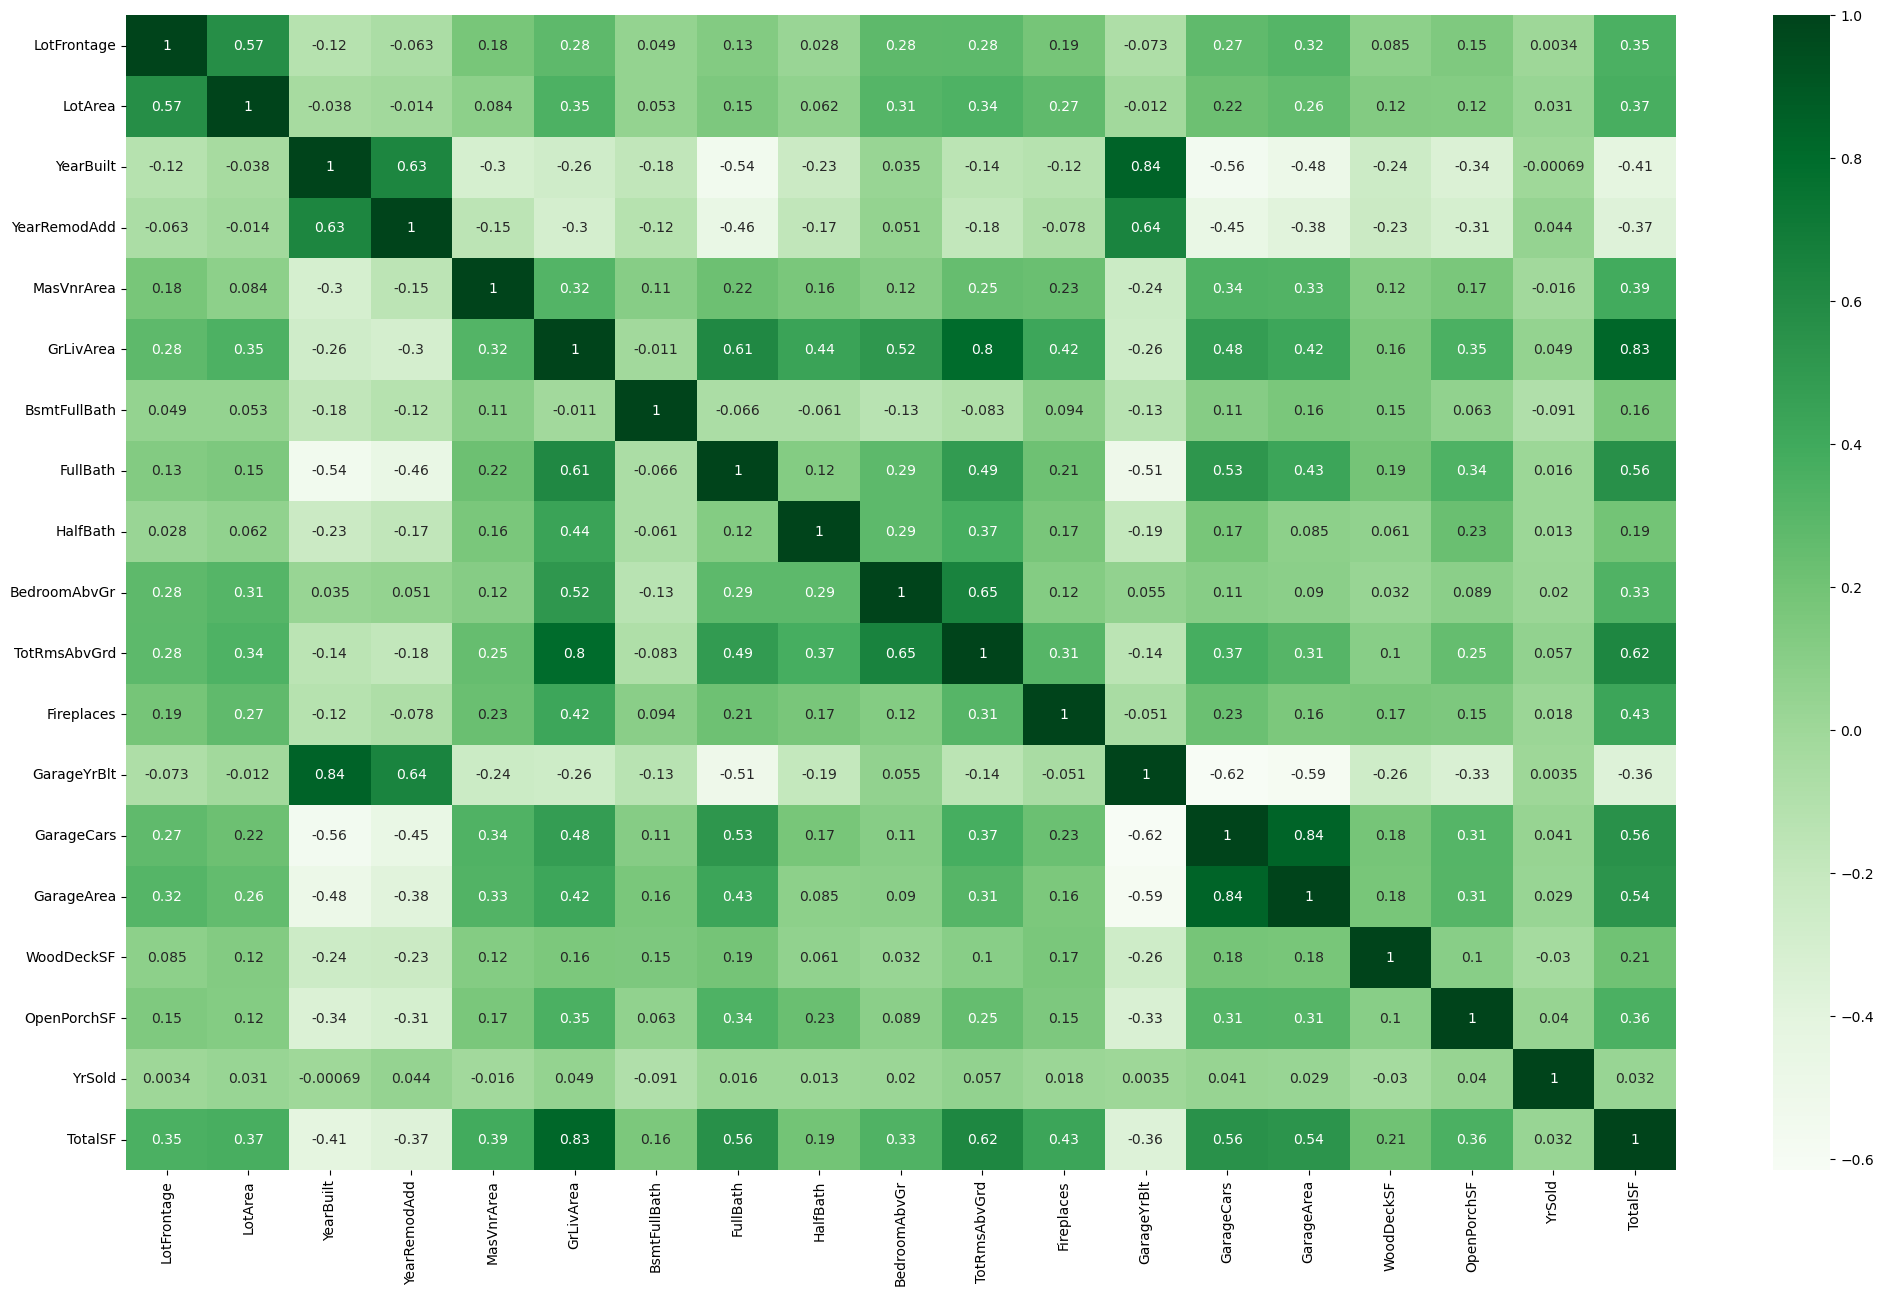

In [33]:
#Plot heatmap to check for collinear relationship
housing_numeric_correlate = housing[numeric_col]
plt.figure(figsize = (25, 15))
sns.heatmap(housing_numeric_correlate.corr(), annot=True, cmap='Greens')
plt.show()

#### Analysis:
We see some strong correlations going on from the heat map above:
- GrLivArea and TotalSF
- GarageArea and GarageCars
- YearBuilt and GarageYrBuilt
- GrLivArea and TotRmsAbvGr

We will have to be careful with the above variables as we build the linear model.

### Categorical Variables
#### Nominal Categorical Variables
For nominal categorical columns where 80% of the values are taken up by just two values and the remaining values take up a meagre 20%, we can combine them into a new category so that dummy variable creation for model building will be easier.

In [34]:
# Group nominal columns
nominal_col = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'HouseStyle',
               'RoofStyle', 'Exterior1st', 'MasVnrType', 'Foundation', 'GarageType', 'MoSold']

two_biased_columns = []
for column in nominal_col:
    # Calculate value counts
    value_counts = housing[column].value_counts()
    total_count = len(housing[column])
    
    # Check if the top two most common values occur more than 80% of the time
    count_high_1 = value_counts.iloc[0]
    count_high_2 = value_counts.iloc[1]
    if ((count_high_1 + count_high_2) / total_count) > 0.8:
        # If yes, combine remaining values into 'Other' category for ease of dummy variable creation later
        top_values = value_counts.nlargest(2).index.tolist()
        housing[column] = housing[column].apply(lambda x: column+'_Other' if x not in top_values else x)
        two_biased_columns.append(column)

print("Number of columns with two values overpowering the rest:",len(two_biased_columns))


Number of columns with two values overpowering the rest: 7


Let us visualize the nominal categorical variables using box plots

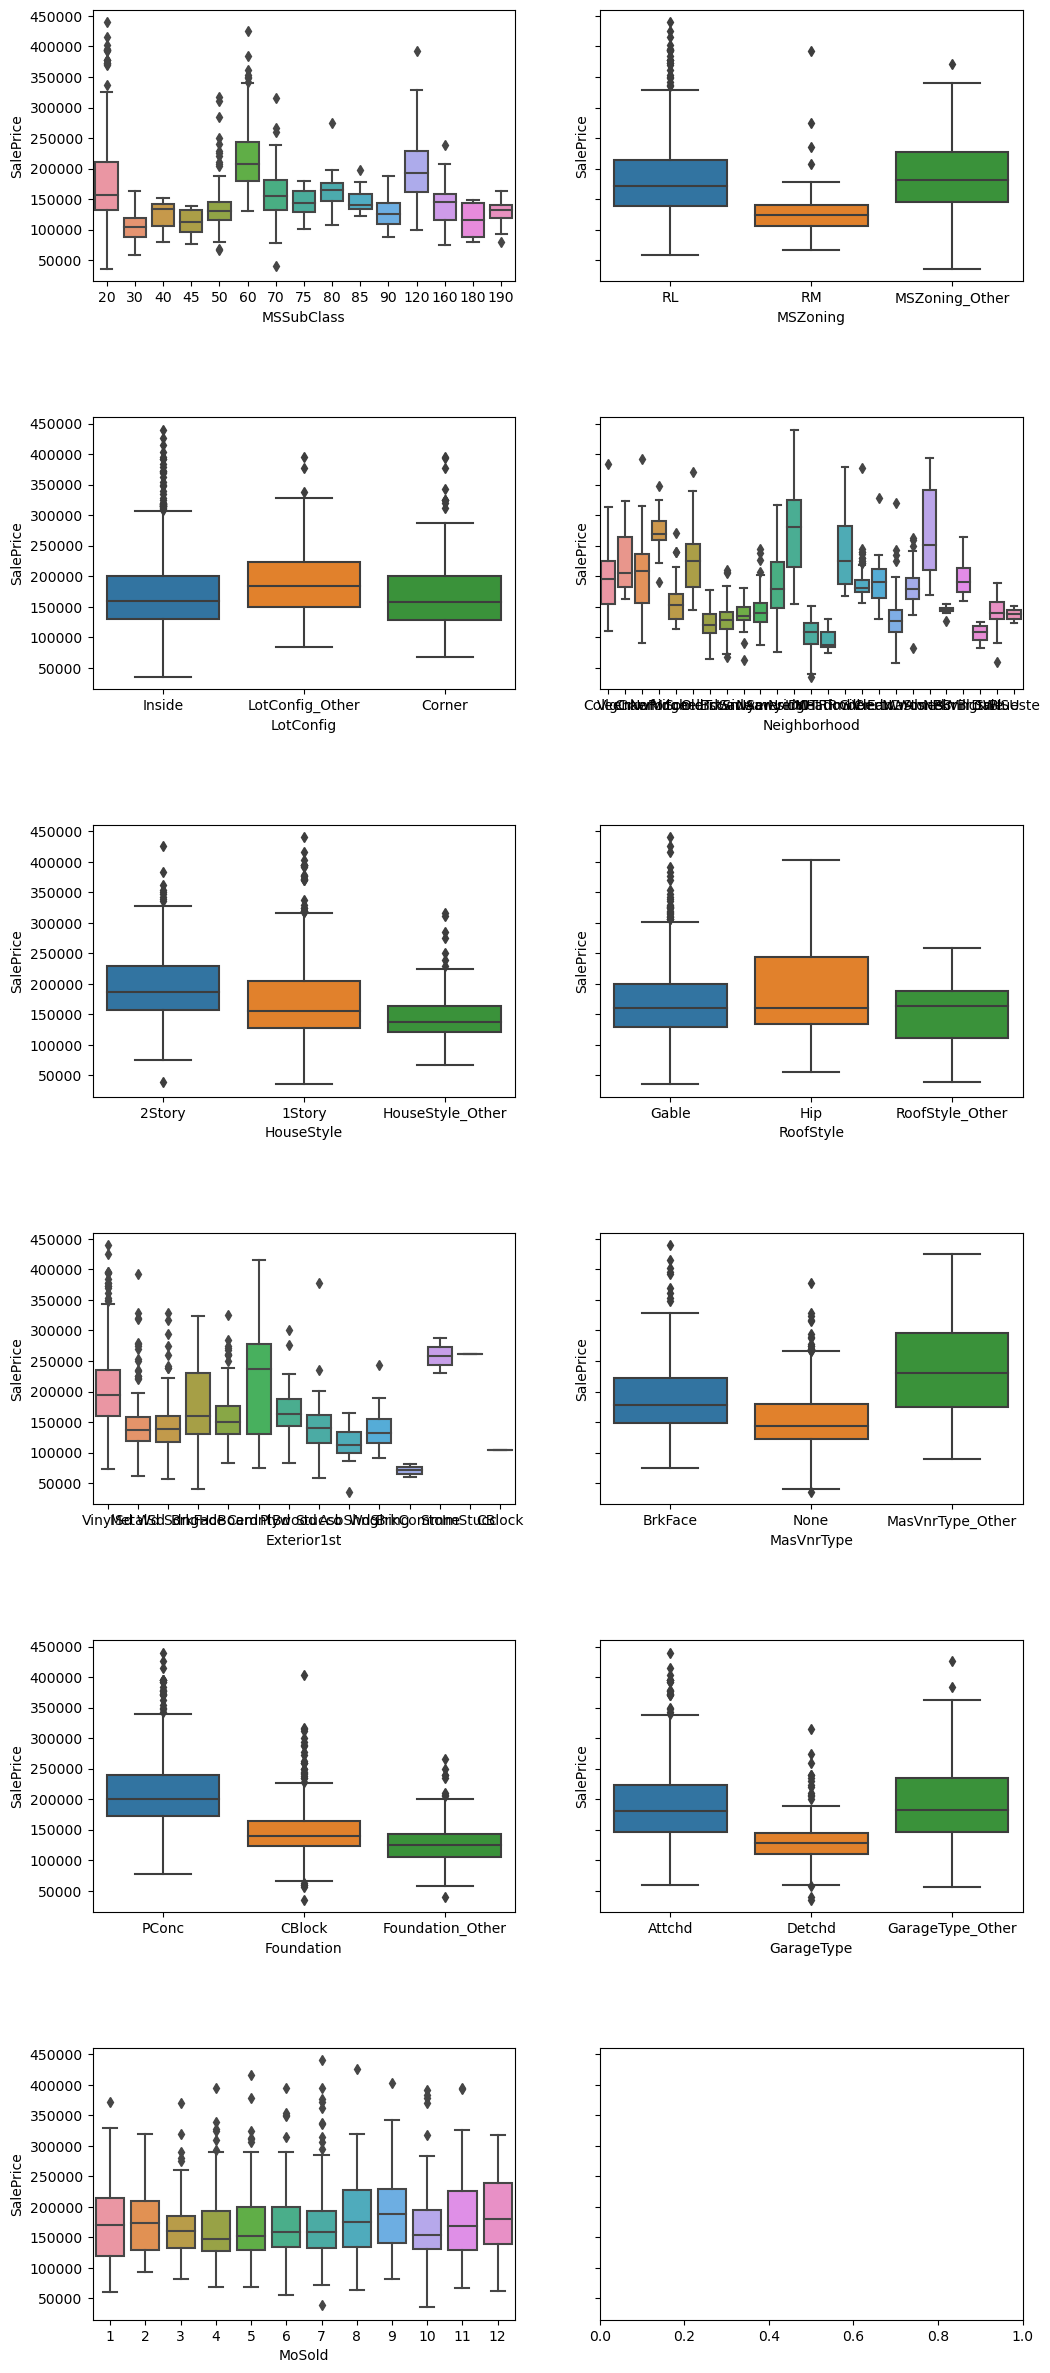

In [35]:
# Create sublist of nominal categorical variables
sublist_size = 2
nominal_sublist = [nominal_col[i:i + sublist_size] for i in range(0, len(nominal_col), sublist_size)]

# Plot box plots to visualize relationship with dependent variable - SalePrice
fig, axes = plt.subplots(6, 2, figsize=(12, 30), sharey=True)
plt.subplots_adjust(hspace=0.5)

for i in range(6):
    for j in range(2):
        if j < len(nominal_sublist[i]):
            col = nominal_sublist[i][j]
            sns.boxplot(x=col, y='SalePrice', data=housing, ax=axes[i, j])
plt.show()

#### Ordinal Categorical Variables

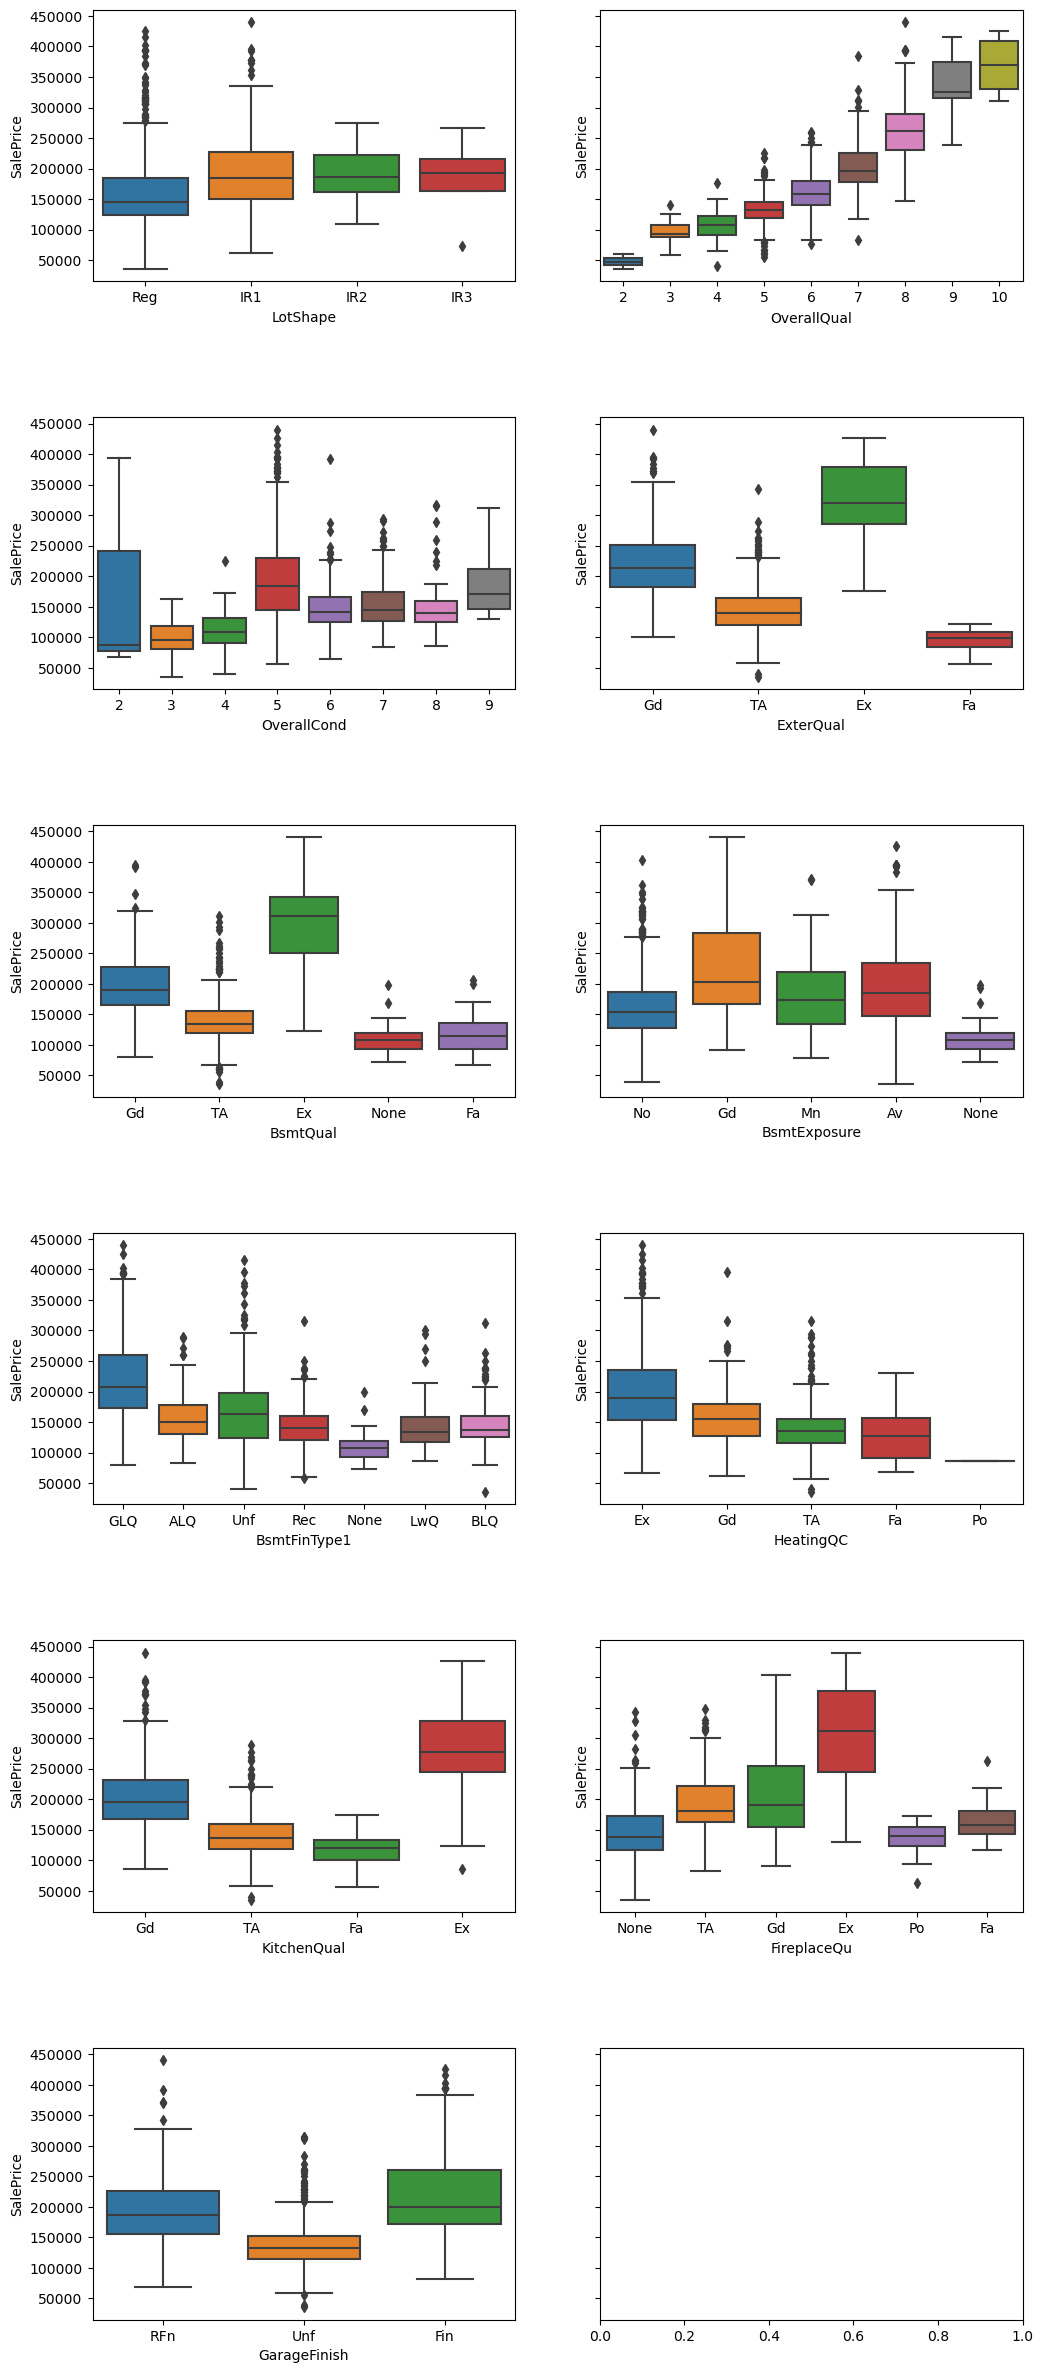

In [36]:
# Group ordinal categorical variables
ordinal_col = ['LotShape', 'OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual',
               'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish']

# Create sublists for ease of plotting
sublist_size = 2
ordinal_sublist = [ordinal_col[i:i + sublist_size] for i in range(0, len(ordinal_col), sublist_size)]

# Plot box plots to visualize relationship with dependent variable - SalePrice
fig, axes = plt.subplots(6, 2, figsize=(12, 30), sharey=True)
plt.subplots_adjust(hspace=0.5)

for i in range(6):
    for j in range(2):
        if j < len(ordinal_sublist[i]):
            col = ordinal_sublist[i][j]
            sns.boxplot(x=col, y='SalePrice', data=housing, ax=axes[i, j])
plt.show()

# Step 5. Data Preparation

### Create Dummy Variables for Nominal Categorical Variables

In [37]:
# Get overview of nominal categorical variables
housing[nominal_col].head()

,MSSubClass,MSZoning,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,MasVnrType,Foundation,GarageType,MoSold
0,60,RL,Inside,CollgCr,2Story,Gable,VinylSd,BrkFace,PConc,Attchd,2
1,20,RL,LotConfig_Other,Veenker,1Story,Gable,MetalSd,None,CBlock,Attchd,5
2,60,RL,Inside,CollgCr,2Story,Gable,VinylSd,BrkFace,PConc,Attchd,9
3,70,RL,Corner,Crawfor,2Story,Gable,Wd Sdng,None,Foundation_Other,Detchd,2
4,60,RL,LotConfig_Other,NoRidge,2Story,Gable,VinylSd,BrkFace,PConc,Attchd,12


In [38]:
# Convert numeric categories to readable values

# Month Sold
month_map = {
    1 : 'Jan',
    2 : 'Feb',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}
housing['MoSold'] = housing['MoSold'].map(month_map)

In [39]:
# Dummy values creation
dummy_col = pd.get_dummies(housing[nominal_col], drop_first=True)
housing = pd.concat([housing,dummy_col],axis=1)
housing = housing.drop(nominal_col, axis=1)
housing.shape

(1175, 93)

### Create ranking for Ordinal Categorical Variables

In [40]:
# Get overview of ordinal categorical variables
housing[ordinal_col].head()

,LotShape,OverallQual,OverallCond,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageFinish
0,Reg,7,5,Gd,Gd,No,GLQ,Ex,Gd,None,RFn
1,Reg,6,8,TA,Gd,Gd,ALQ,Ex,TA,TA,RFn
2,IR1,7,5,Gd,Gd,Mn,GLQ,Ex,Gd,TA,RFn
3,IR1,7,5,TA,TA,No,ALQ,Gd,Gd,Gd,Unf
4,IR1,8,5,Gd,Gd,Av,GLQ,Ex,Gd,TA,RFn


In [41]:
# Create ranking based on values in data dictionary
# Highest ranked = more value
housing['LotShape'] = housing['LotShape'].map({'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1})
housing['ExterQual'] = housing['ExterQual'].map({'TA':2, 'Gd':3, 'Ex':4, 'Fa':1})
housing['BsmtQual'] = housing['BsmtQual'].map({'TA':3, 'Gd':4, 'Ex':5, 'Fa':2, 'None':1})
housing['BsmtExposure'] = housing['BsmtExposure'].map({'No':2, 'Av':4, 'Mn':3, 'Gd':5, 'None':1})
housing['BsmtFinType1'] = housing['BsmtFinType1'].map({'Unf':2, 'GLQ':7, 'ALQ':6, 
                                                       'BLQ':5, 'Rec':4, 'LwQ':3, 'None':1})
housing['HeatingQC'] = housing['HeatingQC'].map({'Ex':5, 'TA':3, 'Gd':4, 'Fa':2, 'Po':1})
housing['KitchenQual'] = housing['KitchenQual'].map({'TA':2, 'Gd':3, 'Ex':4, 'Fa':1})
housing['FireplaceQu'] = housing['FireplaceQu'].map({'None':1, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'Ex':6})
housing['GarageFinish'] = housing['GarageFinish'].map({'Unf':1, 'RFn':2, 'Fin':3})
housing[ordinal_col].head()

,LotShape,OverallQual,OverallCond,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageFinish
0,4,7,5,3,4,2,7,5,3,1,2
1,4,6,8,2,4,5,6,5,2,4,2
2,3,7,5,3,4,3,7,5,3,4,2
3,3,7,5,2,3,2,6,4,3,5,1
4,3,8,5,3,4,4,7,5,3,4,2


In [42]:
# Overview of data being used for model preparation
housing.head()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,65.0,8450,4,7,5,7,7,196.0,3,4,...,0,1,0,0,0,0,0,0,0,0
1,80.0,9600,4,6,8,34,34,0.0,2,4,...,0,0,0,0,0,0,1,0,0,0
2,68.0,11250,3,7,5,9,8,162.0,3,4,...,0,0,0,0,0,0,0,0,0,1
3,60.0,9550,3,7,5,95,40,0.0,2,3,...,0,1,0,0,0,0,0,0,0,0
4,84.0,14260,3,8,5,10,10,350.0,3,4,...,1,0,0,0,0,0,0,0,0,0


In [43]:
# Final list of columns being worked upon
housing.shape

(1175, 93)

We have 1175 rows of data and 93 columns.

### Splitting the Data into Training and Testing Sets
The first step to regression is performing a test-train split.

In [44]:
df_train, df_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features

In [45]:
df_train.describe()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,67.945255,9426.514599,3.620438,6.100973,5.581509,37.024331,25.211679,79.946472,2.396594,3.508516,...,0.040146,0.041363,0.038929,0.163017,0.173966,0.064477,0.125304,0.051095,0.065693,0.042579
std,16.882936,3358.717088,0.564453,1.260580,1.067764,29.220017,20.886071,122.589358,0.552605,0.779956,...,0.196421,0.199249,0.193545,0.369606,0.379311,0.245750,0.331265,0.220325,0.247896,0.202029
min,21.000000,1477.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7588.500000,3.000000,5.000000,5.000000,8.000000,6.000000,0.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,9246.000000,4.000000,6.000000,5.000000,34.000000,17.000000,0.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.000000,11213.000000,4.000000,7.000000,6.000000,56.000000,43.750000,146.750000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,124.000000,22420.000000,4.000000,10.000000,9.000000,130.000000,60.000000,481.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that the numeric variables are at different scales (min-max range).
If a model is built with variables on varying scales, variables that are widely spread will have smaller 𝛽 coefficients and the ones that have a narrow spread will have larger 𝛽 coefficients. This will falsely indicate the effect the predictors have on the dependent variable.

Therefore, rescaling them will help build a better model. We will use MinMax scaling.
We will fit and transform only the `training set` first for building the model.
Then, we will transform the `test set` to the same scale.

In [46]:
scaler = MinMaxScaler()

# Apply scaler() to all the columns in the training dataset
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_train.describe()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,0.455779,0.379579,0.873479,0.512622,0.511644,0.284803,0.420195,0.166209,0.465531,0.627129,...,0.040146,0.041363,0.038929,0.163017,0.173966,0.064477,0.125304,0.051095,0.065693,0.042579
std,0.163912,0.160374,0.188151,0.157572,0.152538,0.224769,0.348101,0.254864,0.184202,0.194989,...,0.196421,0.199249,0.193545,0.369606,0.379311,0.245750,0.331265,0.220325,0.247896,0.202029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378641,0.291816,0.666667,0.375000,0.428571,0.061538,0.100000,0.000000,0.333333,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.466019,0.370959,1.000000,0.500000,0.428571,0.261538,0.283333,0.000000,0.333333,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.533981,0.464881,1.000000,0.625000,0.571429,0.430769,0.729167,0.305094,0.666667,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
# Transform the test data set to the same min-max scale
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])
df_test.describe()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,0.455843,0.360548,0.870633,0.501062,0.519223,0.293419,0.411520,0.171821,0.453258,0.615439,...,0.042493,0.031161,0.025496,0.178470,0.150142,0.070822,0.198300,0.048159,0.065156,0.031161
std,0.179536,0.160293,0.175729,0.155249,0.155276,0.220173,0.341456,0.264531,0.169771,0.181599,...,0.201997,0.174001,0.157849,0.383452,0.357717,0.256891,0.399286,0.214405,0.247151,0.174001
min,0.000000,-0.008452,0.000000,0.125000,0.142857,0.007692,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378641,0.273266,0.666667,0.375000,0.428571,0.076923,0.100000,0.000000,0.333333,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.466019,0.365659,1.000000,0.500000,0.428571,0.292308,0.250000,0.000000,0.333333,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.553398,0.443680,1.000000,0.625000,0.571429,0.430769,0.733333,0.280665,0.666667,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.968008,1.000000,1.000000,1.000000,0.961538,1.000000,1.060291,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X and Y Sets for Model Building

In [48]:
#Split df_train and df_test into X and y sets 
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

### Recursive Feature Elimination for Feature Selection
RFE is an automated feature selection technique used to identify and select the most important features from a dataset. It is often used as a preprocessing step to reduce the dimensionality of data before applying a linear regression model. 

In [49]:
# Running RFE with the output number of the variable equal to 40
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=40)     
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('LotShape', False, 16),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 35),
 ('MasVnrArea', True, 1),
 ('ExterQual', True, 1),
 ('BsmtQual', True, 1),
 ('BsmtExposure', True, 1),
 ('BsmtFinType1', True, 1),
 ('HeatingQC', False, 38),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('FullBath', True, 1),
 ('HalfBath', False, 28),
 ('BedroomAbvGr', True, 1),
 ('KitchenQual', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('Fireplaces', False, 17),
 ('FireplaceQu', False, 49),
 ('GarageYrBlt', False, 31),
 ('GarageFinish', False, 14),
 ('GarageCars', False, 27),
 ('GarageArea', True, 1),
 ('WoodDeckSF', True, 1),
 ('OpenPorchSF', True, 1),
 ('YrSold', False, 46),
 ('TotalSF', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', False, 7),
 ('LotConfig_Inside', False, 9),
 ('LotConfig_LotConfig_Other', False, 8),
 ('Neighborhood_Blueste', False, 19),
 ('Neighborhood_BrDale', False, 5

#### Columns Chosen Through RFE

In [50]:
# Columns chosen through RFE
rfe_housing_columns = X_train.columns[rfe.support_]
rfe_housing_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF',
       'MSZoning_RL', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_NPkVill',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Plywood',
       'Exterior1st_Stone', 'Exterior1st_Stucco'],
      dtype='object')

#### Columns Eliminated by RFE

In [51]:
# Columns eliminated by RFE
X_train.columns[~rfe.support_]

Index(['LotShape', 'YearRemodAdd', 'HeatingQC', 'HalfBath', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'YrSold',
       'MSZoning_RM', 'LotConfig_Inside', 'LotConfig_LotConfig_Other',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_CollgCr',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'HouseStyle_2Story',
       'HouseStyle_HouseStyle_Other', 'RoofStyle_Hip',
       'RoofStyle_RoofStyle_Other', 'Exterior1st_CBlock',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing',
       'MasVnrType_MasVnrType_Other', 'MasVnrType_None',
       'Foundation_Foundation_Other', 'Foundation_PConc', 'GarageType_Detchd',
       'GarageType_GarageType_Other', 'MoSold_Aug', 'MoSold_Dec', 'Mo

In [52]:
X_train = X_train[rfe_housing_columns]
X_test = X_test[rfe_housing_columns]

# Step 6: Model Building and Evaluation
## Multiple Linear Regression
Build the model using Multiple Linear Regression with the columns selected by RFE. Let's calculate coefficients.

In [53]:
lm.fit(X_train, y_train)

LinearRegression()

In [54]:
# Print the coefficients and intercept
print('Multiple Linear Regression:')
print('Intercept:',lm.intercept_)
print('Coefficients:',lm.coef_)

Multiple Linear Regression:
Intercept: -0.09650864416527621
Coefficients: [ 0.05620961  0.09425582  0.16628963  0.0831901  -0.13880121  0.01696857
  0.03779096  0.03050261  0.0276852   0.02193176  0.16456076  0.02602865
 -0.02337033 -0.03605595  0.05858679  0.06170659  0.05894169  0.02649587
  0.01992519  0.15465045  0.01815821  0.05415415  0.02958432  0.05990701
  0.02664176  0.05034643  0.0183738   0.09116596  0.01578342  0.02338929
  0.03823215  0.09898374  0.03711046  0.03021157  0.08689247  0.05405793
  0.02458974 -0.01909578 -0.08137687  0.03610204]


In [55]:
print('Metrics for Multiple Linear Regression:')
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS score on training set:',rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS score on test set:',rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric.append(mse_test_lr**0.5)

Metrics for Multiple Linear Regression:
R-squared on training set: 0.8939860188465207
R-squared on test set: 0.8765937140512202
RSS score on training set: 2.1000569633283446
RSS score on test set: 0.9675560626305125
MSE on training set: 0.002554813824000419
MSE on test set: 0.0027409520187833217


## Ridge Regression

In [56]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation using GridSearchCV
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [57]:
print('For Ridge:',model_cv.best_params_)

For Ridge: {'alpha': 1.0}


In [58]:
#Fitting Ridge model for alpha = 1 and printing coefficients which have been penalised
alpha = 1
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.05612115  0.08781752  0.15804875  0.07243042 -0.11470932  0.0189729
  0.04551787  0.04082655  0.02825149  0.02235616  0.15032947  0.02535315
 -0.01044696 -0.03200618  0.06187606  0.06441399  0.06280853  0.02737136
  0.0218187   0.14571148  0.01768439  0.04732794  0.02716199  0.05709005
  0.01762076  0.03853254  0.01879292  0.08862364  0.00937317  0.01560666
  0.03602335  0.09249139  0.03436024  0.02859563  0.04134152  0.05288829
  0.02377335 -0.01798944 -0.03446226  0.03367021]


In [59]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
print('Metrics for Ridge Regression:')
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS on training set:',rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS on test set:',rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric2.append(mse_test_lr**0.5)

Metrics for Ridge Regression:
R-squared on training set: 0.8932948499054953
R-squared on test set: 0.8773250901609873
RSS on training set: 2.1137484984602573
RSS on test set: 0.961821772973972
MSE on training set: 0.0025714701927740356
MSE on test set: 0.0027247075721642264


## Lasso Regression

In [60]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [61]:
# Printing the best hyperparameter alpha
print('For Lasso:', model_cv.best_params_)

For Lasso: {'alpha': 0.0001}


In [62]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
print(lasso.coef_)

[ 0.05425208  0.0883905   0.17267675  0.07174499 -0.1089518   0.0147138
  0.04301533  0.03356467  0.02743867  0.02241812  0.15908637  0.02467347
 -0.00657749 -0.02933322  0.06083021  0.05130483  0.06229136  0.02671193
  0.01915017  0.15497708  0.01322143  0.04034005  0.01770246  0.05198366
  0.007739    0.02594927  0.00945683  0.08899828  0.00115463  0.00613348
  0.03147792  0.09105977  0.02798325  0.01861634  0.          0.05090364
  0.02009722 -0.01614407 -0.          0.03029082]


In [63]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
print('Metrics for Lasso Regression:')
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS on training set:',rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS on test set:',rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric3.append(mse_test_lr**0.5)

Metrics for Lasso Regression:
R-squared on training set: 0.8923196412814588
R-squared on test set: 0.8790778168914484
RSS on training set: 2.1330666453624185
RSS on test set: 0.9480796741728132
MSE on training set: 0.002594971588032139
MSE on test set: 0.0026857781138040033


# Step 7: Model Interpretation
### Tabulate all metrics for easy comparison

In [64]:
# Creating a table which contains all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge (alpha = 1.0)')
ls_metric = pd.Series(metric3, name = 'Lasso (alpha = 0.001)')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge (alpha = 1.0),Lasso (alpha = 0.001)
0,R2 Score (Train),0.893986,0.893295,0.892320
1,R2 Score (Test),0.876594,0.877325,0.879078
2,RSS (Train),2.100057,2.113748,2.133067
3,RSS (Test),0.967556,0.961822,0.948080
4,MSE (Train),0.050545,0.050710,0.050941
5,MSE (Test),0.052354,0.052199,0.051824


- Higher the R-squared value, better the model
- Lower the RSS and MSE values, better the model
- The best R-squared value, lease RSS and MSE values are obtained using `Lasso Regression`. 
- Therefore, we can conclude that Lasso has built the model better than Simple Linear Regression and Ridge Regression.
## Lasso has built the better model amongst the three models. 
### Changes in Coefficients after Regularization

In [65]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,0.056210,0.056121,0.054252
LotArea,0.094256,0.087818,0.088390
OverallQual,0.166290,0.158049,0.172677
OverallCond,0.083190,0.072430,0.071745
YearBuilt,-0.138801,-0.114709,-0.108952
MasVnrArea,0.016969,0.018973,0.014714
ExterQual,0.037791,0.045518,0.043015
BsmtQual,0.030503,0.040827,0.033565
BsmtExposure,0.027685,0.028251,0.027439
BsmtFinType1,0.021932,0.022356,0.022418


### Best Values of Alpha for Ridge and Lasso
- Ridge: 1.0
- Lasso: 0.0001

# Step 8: Addressing the Business Problem

### Which variables are significant in predicting the price of a house (Top 10)

Considering Lasso as the most dependable model, following are the significant variables:

In [66]:
# The top 10 variables that have a significant impact on the `Sale Price` according to the Lasso model
betas = betas.iloc[betas['Lasso'].abs().argsort()[::-1]]

# Print the sorted DataFrame
betas['Lasso'].head(10)

OverallQual             0.172677
GrLivArea               0.159086
TotalSF                 0.154977
YearBuilt              -0.108952
Neighborhood_StoneBr    0.091060
Neighborhood_NridgHt    0.088998
LotArea                 0.088390
OverallCond             0.071745
GarageArea              0.062291
KitchenQual             0.060830
Name: Lasso, dtype: float64

The top 10 variables that are instrumental in predicting the SalePrice:
1. OverallQual - `positive` - Rates the overall material and finish of the house
2. GrLivArea - `positive` - Above grade (ground) living area square feet
3. TotalSF - `positive` - Summation of area of basement, first floor and second floor
4. YearBuilt - `negative` - The age of the house
5. Neighborhood_StoneBr - `positive` - Houses in the Stone Brook region are sold at a high price
6. Neighboorhood_NridgHt - `positive` - Houses in the Northridge Heights region are sold at a high price
7. LotArea - `positive` - Lot size in square feet
8. OverallCond - `positive` - Rates the overall condition of the house
9. GarageArea - `positive` - Size of garage in square feet
10. KitchenQual - `positive` - Kitchen Quality

### How well do these variables describe the price of a house?

1. `OverallQual` - For every unit increase in overall quality of the house, the sale price for a house is expected to increase by approximately 0.17 units (holding all other variables constant).
2. `GrLivArea` - For every unit increase in the square feet of good grade living area, the sale price for a house is expected to increase by approximately 0.16 units (holding all other variables constant).
3. `TotalSF` - For every unit increase in the square feet of the entire house, the sale price for a house is expected to increase by approximately 0.15 units (holding all other variables constant).
4. `YearBuilt` - This variable describes the age of the house (changed using Feature Engineering). As the house gets older by a year, the sale price for a house is expected to decrease by approximately 0.11 units (holding all other variables constant).
5. `Neighborhood_StoneBr` - Houses in the Stone Brook region are sold at a high price of about 0.091 units more in comparison to houses in Bloomington Heights (holding all other variables constant).
6. `Neighborhood_NridgHt` - Houses in the Northridge Heights region are sold at a high price of about 0.089 units more in comparison to houses in Bloomington Heights (holding all other variables constant).
7. `Lot Area` - For every unit increase in the square feet of the lot area, the sale price for a house is expected to increase by approximately 0.088 units (holding all other variables constant).
8. `OverallCond` - For every unit increase in the rating of the overall condition of the house, the sale price for a house is expected to increase by approximately 0.07 units (holding all other variables constant).
9. `GarageArea` - For every unit increase in the square feet of the garage area, the sale price for a house is expected to increase by approximately 0.062 units (holding all other variables constant).
10. `KitchenQual` - For every unit increase in the rating of the kitchen quality, the sale price for a house is expected to increase by approximately 0.06 units (holding all other variables constant).

# Subjective Questions 

### 1. What will be the changes in the model if you choose to double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?
Doubled alpha valus for:
- Ridge: 2.0
- Lasso: 0.0002

#### Rebuild Ridge Model

In [67]:
#Fitting Ridge model for alpha = 2 and printing coefficients which have been penalised
alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.05550673  0.08307723  0.15087298  0.06508574 -0.09929939  0.0204687
  0.05054678  0.04768094  0.02894936  0.02270127  0.14095598  0.02501851
 -0.00178342 -0.02908541  0.06448389  0.06646117  0.06499126  0.02774981
  0.02334908  0.13940321  0.01759063  0.04266563  0.02504633  0.05496767
  0.01199527  0.03075959  0.01857297  0.08650078  0.00543617  0.01071932
  0.03444961  0.08678288  0.03307382  0.02677355  0.02656108  0.05170455
  0.02317084 -0.01724979 -0.0202975   0.03157716]


#### Rebuild Lasso Model

In [68]:
#Fitting Lasso model for alpha = 0.0002 and printing coefficients which have been penalised

alpha =0.0002
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
print(lasso.coef_)

[ 0.05049296  0.08363104  0.17836081  0.06314222 -0.09638846  0.01242213
  0.04612611  0.03495895  0.02763476  0.02342121  0.15699472  0.02356934
 -0.         -0.02338431  0.0622282   0.04364246  0.06302927  0.0260518
  0.01843998  0.15780043  0.01282419  0.03372909  0.00654644  0.04782729
  0.          0.00271783  0.          0.08648877 -0.          0.
  0.02753695  0.08257663  0.02276669  0.00573824  0.          0.04853279
  0.01688016 -0.01218617 -0.          0.02296639]


#### Identify the top predictor variables

In [69]:
# Map predictor variables with their coefficients for Lasso and Ridge
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)

# The top 10 variables that have a significant impact on the `Sale Price` according to the Ridge model
betas = betas.iloc[betas['Ridge'].abs().argsort()[::-1]]
betas['Ridge'].head(10)

OverallQual             0.150873
GrLivArea               0.140956
TotalSF                 0.139403
YearBuilt              -0.099299
Neighborhood_StoneBr    0.086783
Neighborhood_NridgHt    0.086501
LotArea                 0.083077
TotRmsAbvGrd            0.066461
OverallCond             0.065086
GarageArea              0.064991
Name: Ridge, dtype: float64

In [70]:
# The top 10 variables that have a significant impact on the `Sale Price` according to the Lasso model
betas = betas.iloc[betas['Lasso'].abs().argsort()[::-1]]
betas['Lasso'].head(10)

OverallQual             0.178361
TotalSF                 0.157800
GrLivArea               0.156995
YearBuilt              -0.096388
Neighborhood_NridgHt    0.086489
LotArea                 0.083631
Neighborhood_StoneBr    0.082577
OverallCond             0.063142
GarageArea              0.063029
KitchenQual             0.062228
Name: Lasso, dtype: float64

### 2. You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

#### Calculate metrics for Ridge regression

In [71]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
print('Metrics for Ridge Regression:')
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS on training set:',rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS on test set:',rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric2.append(mse_test_lr**0.5)

Metrics for Ridge Regression:
R-squared on training set: 0.8921523678850394
R-squared on test set: 0.8757887152346162
RSS on training set: 2.1363802051128213
RSS on test set: 0.9738675846038654
MSE on training set: 0.002599002682619004
MSE on test set: 0.0027588316844302137


#### Calculate metrics for Lasso regression

In [72]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
print('Metrics for Lasso Regression:')
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS on training set:',rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS on test set:',rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric3.append(mse_test_lr**0.5)

Metrics for Lasso Regression:
R-squared on training set: 0.8903954903982446
R-squared on test set: 0.8761818385604184
RSS on training set: 2.1711826223007633
RSS on test set: 0.9707853359621772
MSE on training set: 0.002641341389660296
MSE on test set: 0.002750100101875856


#### Tabulate metrics for easy comparison

In [73]:
# Creating a table which contains all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric'] )

rg_metric_d = pd.Series(metric2, name = 'Ridge (alpha = 2.0)')
ls_metric_d = pd.Series(metric3, name = 'Lasso (alpha = 0.002)')

final_metric_d = pd.concat([lr_metric, rg_metric_d, ls_metric_d], axis = 1)

final_metric_d

,Metric,Ridge (alpha = 2.0),Lasso (alpha = 0.002)
0,R2 Score (Train),0.892152,0.890395
1,R2 Score (Test),0.875789,0.876182
2,RSS (Train),2.136380,2.171183
3,RSS (Test),0.973868,0.970785
4,MSE (Train),0.050980,0.051394
5,MSE (Test),0.052525,0.052441


#### Tabulate metrics for both optimal alpha and doubled alpha

In [74]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric'] )
all_metrics = pd.concat([lr_metric, rg_metric, ls_metric, rg_metric_d, ls_metric_d], axis = 1)

all_metrics

,Metric,Ridge (alpha = 1.0),Lasso (alpha = 0.001),Ridge (alpha = 2.0),Lasso (alpha = 0.002)
0,R2 Score (Train),0.893295,0.892320,0.892152,0.890395
1,R2 Score (Test),0.877325,0.879078,0.875789,0.876182
2,RSS (Train),2.113748,2.133067,2.136380,2.171183
3,RSS (Test),0.961822,0.948080,0.973868,0.970785
4,MSE (Train),0.050710,0.050941,0.050980,0.051394
5,MSE (Test),0.052199,0.051824,0.052525,0.052441


### 3. After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

The top 5 predictor variables in Lasso are:
- OverallQual             
- GrLivArea          
- TotalSF        
- YearBuilt
- Neighborhood_StoneBr

Let us drop them and rebuild Lasso model.

In [75]:
# Drop the top 5 important predictor variables from rfe_housing_columns
lasso_top5 = ['OverallQual', 'GrLivArea', 'TotalSF', 'YearBuilt', 'Neighborhood_StoneBr']
rfe_housing_columns_minus5 =  list(set(rfe_housing_columns).difference(set(lasso_top5)))

# Build X training and test data
X_train = X_train[rfe_housing_columns_minus5]
X_test = X_test[rfe_housing_columns_minus5]

# Initiate Lasso
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [76]:
# Printing the best hyperparameter alpha
print('For Lasso:', model_cv.best_params_)

For Lasso: {'alpha': 0.0001}


In [77]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
print(lasso.coef_)

[-0.03412386  0.04732698  0.03398005  0.11000016  0.02460902  0.
  0.19150193  0.03325431  0.10371396  0.0384899   0.04376656  0.02416176
  0.0242998   0.06412643  0.03068226  0.0377836   0.01889761  0.0329073
  0.06383398  0.0843196   0.06026439 -0.00985639  0.03188633  0.11249113
  0.03857222  0.04799992  0.15693209  0.09268804 -0.01118365  0.03605967
 -0.00825887  0.          0.06437655 -0.          0.03036264]


In [78]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

print('Metrics for Lasso Regression:')
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R-squared on training set:',r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS on training set:',rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS on test set:',rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE on training set:',mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE on test set:',mse_test_lr)
metric3.append(mse_test_lr**0.5)

Metrics for Lasso Regression:
R-squared on training set: 0.8405922253530348
R-squared on test set: 0.7960923518473044
RSS on training set: 3.157747718872912
RSS on test set: 1.5987198680361947
MSE on training set: 0.003841542237071669
MSE on test set: 0.004528951467524631


In [79]:
# Identify the next top 5 predictor variables
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas = betas.iloc[betas['Lasso'].abs().argsort()[::-1]]
betas['Lasso'].head(5)

TotRmsAbvGrd    0.191502
BsmtQual        0.156932
KitchenQual     0.112491
ExterQual       0.110000
GarageArea      0.103714
Name: Lasso, dtype: float64